In [1]:
%matplotlib inline


Object Detection From TF2 Checkpoint
====================================


This demo will take you through the steps of running an "out-of-the-box" TensorFlow 2 compatible
detection model on a collection of images. More specifically, in this example we will be using
the `Checkpoint Format <https://www.tensorflow.org/guide/checkpoint>`__ to load the model.



In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

def get_true_y(csv, img_error_lst):  
    true_y_col = csv["label_SIJ"].to_list()
    true_y = []
    
    filename_lst = sorted(list(set(csv["Filename"].to_list())))
    for i, file in enumerate(filename_lst):
        if file in img_error_lst:
            continue
        label = [true_y_col[2*i],true_y_col[2*i+1]]
        true_y += label
    true_y = np.array(true_y)
    true_y[true_y=="negative"] = 0
    true_y[true_y=="positive"] = 1
    true_y = list(map(int, true_y))
    print(true_y, len(true_y))
    return true_y

# get biggest prediction result
def get_pred_y(prediction_lst):
    pred_y = []
    score_dict = {}
    for output_dict in prediction_lst[:]:
        detection_scores = output_dict["detection_scores"]
        detection_classes = output_dict["detection_classes"]
    #    print(detection_classes[:6])
    #    print(detection_scores[:6])
        detection_boxes = output_dict["detection_boxes"] #ymin, xmin, ymax, xmax
        filename = output_dict["filename"]
        position = ["right" if i[1] > 0.5 else "left" for i in detection_boxes]
    #    print(position, position.index("right"), position.index("left"))
        pred_y += [detection_classes[position.index("right")],detection_classes[position.index("left")]]
        score_dict[filename] = (detection_scores[position.index("right")],detection_scores[position.index("left")])

    print(pred_y)
    return pred_y, score_dict

# classification results

def visualize_classification_result(true_y, pred_y):
    cm = confusion_matrix(true_y, pred_y, normalize='true')
    print(classification_report(true_y, pred_y))
    
    plt.figure()
    classes = [0,1]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, round(cm[i, j], 3),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

import pandas as pd
from sklearn.metrics import confusion_matrix
import collections

PATH_TO_MODEL_DIR ="/home/user/TensorFlow/workspace/training_AS/models/efficientdet_d4_coco17_tpu-32"
PATH_TO_LABELS = "/home/user/TensorFlow/workspace/training_AS/annotations/label_map.pbtxt"

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)
PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR

PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/home/user/TensorFlow/workspace/training_AS/images/test/')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))

csvpath = "/home/user/TensorFlow/workspace/training_AS/images/test/test.csv"
csv = pd.read_csv(csvpath)
csv = csv.sort_values(by=["Filename", "BX"])

index_lst = [15, 16, 17, 18, 19, 20, 21]

/home/user/TensorFlow/workspace/training_AS/exported-models/my_model_200925/efficientdet_d4_coco17_tpu-32/ckpt-15
Loading model... Done! Took 13.942457675933838 seconds
# error image count71
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1] 238
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,

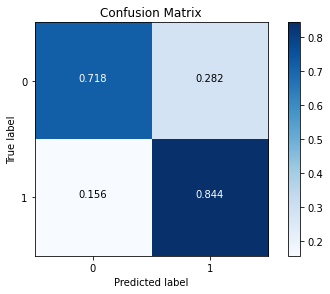

/home/user/TensorFlow/workspace/training_AS/exported-models/my_model_200925/efficientdet_d4_coco17_tpu-32/ckpt-16
Loading model... Done! Took 17.724125385284424 seconds
# error image count71
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1] 238
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,

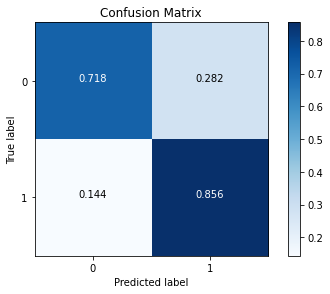

/home/user/TensorFlow/workspace/training_AS/exported-models/my_model_200925/efficientdet_d4_coco17_tpu-32/ckpt-17
Loading model... Done! Took 17.430806398391724 seconds
# error image count71
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1] 238
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,

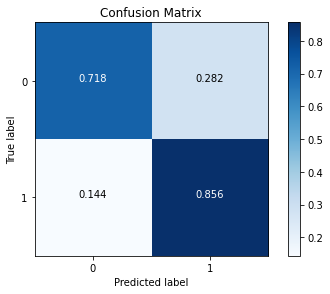

/home/user/TensorFlow/workspace/training_AS/exported-models/my_model_200925/efficientdet_d4_coco17_tpu-32/ckpt-18
Loading model... Done! Took 16.780142307281494 seconds


KeyboardInterrupt: 

In [10]:
for index in index_lst:
    print(os.path.join(PATH_TO_CKPT, 'ckpt-'+str(index)))
    print('Loading model... ', end='')
    start_time = time.time()

    # Load pipeline config and build a detection model
    configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
    model_config = configs['model']
    detection_model = model_builder.build(model_config=model_config, is_training=False)

    # Restore checkpoint
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-'+str(index))).expect_partial()
    
    @tf.function
    def detect_fn(image):
        """Detect objects in image."""

        image, shapes = detection_model.preprocess(image)
        prediction_dict = detection_model.predict(image, shapes)
        detections = detection_model.postprocess(prediction_dict, shapes)

        return detections

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('Done! Took {} seconds'.format(elapsed_time))


    count = 0
    error_imgs = []
    prediction_lst = []

    for image_path in TEST_IMAGE_PATHS:

 #       print('Running inference for {}... '.format(image_path), end='')

        image_np = np.array(Image.open(image_path))

        # Things to try:
        # Flip horizontally
        # image_np = np.fliplr(image_np).copy()

        # Convert image to grayscale
        # image_np = np.tile(
        #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

        try:
            detections = detect_fn(input_tensor)
            # All outputs are batches tensors.
            # Convert to numpy arrays, and take index [0] to remove the batch dimension.
            # We're only interested in the first num_detections.
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                          for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

            detections["filename"] = image_path
            prediction_lst.append(detections)

            label_id_offset = 1
            image_np_with_detections = image_np.copy()

    #        viz_utils.visualize_boxes_and_labels_on_image_array(
    #                image_np_with_detections,
    #                detections['detection_boxes'],
    #                detections['detection_boxes'],
    #                detections['detection_classes']+label_id_offset,
    #                detections['detection_scores'],
    #                category_index,
    #                use_normalized_coordinates=True,
    #                max_boxes_to_draw=6,
    #                min_score_thresh=.30,
    #                detections['detection_boxes'],
    #                agnostic_mode=False)
    #        display(Image.fromarray(image_np_with_detections))

        except Exception as ex:
            count += 1
            error_imgs.append(image_path)
  #          print(image_path)
  #          print(ex)

    print("# error image count" + str(count))
    
    img_error_lst = [error_img.name for error_img in error_imgs]

    true_y = get_true_y(csv, img_error_lst)
    pred_y, score_dict = get_pred_y(prediction_lst)
    visualize_classification_result(true_y, pred_y)

   